# Comparison of disk storage methods

This notebook is used to compare PyTables, an HDF5 Python implementation, with Numpy's native .npy/.npz file format

In [1]:
import tables

import pandas as pd
from neo4j.v1 import GraphDatabase
import hetio.readwrite
import hetio.neo4j
import hetio.pathtools
import numpy as np
from scipy import sparse
import time
from hetmech.matrix import get_node_to_position, metaedge_to_adjacency_matrix
import plotnine as pln

/home/michael/miniconda3/envs/hetmech/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
url = 'https://github.com/dhimmel/hetionet/raw/76550e6c93fbe92124edc71725e8c7dd4ca8b1f5/hetnet/json/hetionet-v1.0.json.bz2'
graph = hetio.readwrite.read_graph(url)
metagraph = graph.metagraph

In [3]:
# Sparse matrices out of .npz
times1=[]
for i in range(100):
    t1 = time.time()
    sparse_gig_adj_load_sp = sparse.load_npz('data/sparse_gig_adj.npz')
    sparse_ctd_adj_load_sp = sparse.load_npz('data/sparse_ctd_adj.npz')
    t2 = time.time()
    times1.append(t2-t1)
print(f'Average: {np.mean(times1)*1000 :.4} ms, Stdev: {np.std(times1)*1000 :.4} ms, Max: {np.max(times1)*1000 :.4} ms')

Average: 4.203 ms, Stdev: 0.1245 ms, Max: 5.199 ms


# NPY Saving and loading

In [4]:
r, c, gig_adj = metaedge_to_adjacency_matrix(graph, 'GiG')
r, c, ctd_adj = metaedge_to_adjacency_matrix(graph, 'CtD')
r, c, sparse_gig_adj = metaedge_to_adjacency_matrix(graph, 'GiG', sparse_threshold=1)
r, c, sparse_ctd_adj = metaedge_to_adjacency_matrix(graph, 'CtD', sparse_threshold=1)

## Save matrices

#### np.save

In [5]:
# Dense matrices into .npy
t1 = time.time()
np.save('data/gig_adj', gig_adj)
np.save('data/ctd_adj', ctd_adj)
t2 = time.time()
print(f'{(t2 - t1)*1000 :.4} ms')

639.3 ms


In [6]:
# Sparse matrices into .npy
t1 = time.time()
np.save('data/sparse_gig_adj', sparse_gig_adj)
np.save('data/sparse_ctd_adj', sparse_ctd_adj)
t2 = time.time()
print(f'{(t2 - t1)*1000 :.4} ms')

5.324 ms


#### sparse.save_npz

In [7]:
# Sparse matrices into .npz with compression
t1 = time.time()
sparse.save_npz('data/sparse_gig_adj', sparse_gig_adj, compressed=True)
sparse.save_npz('data/sparse_ctd_adj', sparse_ctd_adj, compressed=True)
t2 = time.time()
print(f'{(t2 - t1)*1000 :.4} ms')

218.1 ms


In [8]:
# Sparse matrices into .npz without compression
t1 = time.time()
sparse.save_npz('data/sparse_gig_adj', sparse_gig_adj, compressed=False)
sparse.save_npz('data/sparse_ctd_adj', sparse_ctd_adj, compressed=False)
t2 = time.time()
print(f'{(t2 - t1)*1000 :.4} ms')

6.05 ms


## Load matrices

#### np.load

In [9]:
# Dense matrices out of .npy
t1 = time.time()
gig_adj_load = np.load('data/gig_adj.npy')
ctd_adj_load = np.load('data/ctd_adj.npy')
t2 = time.time()
print(f'{(t2 - t1)*1000 :.4} ms')

90.51 ms


In [10]:
# Sparse matrices out of .npy
t1 = time.time()
sparse_gig_adj_load = np.load('data/sparse_gig_adj.npy')
sparse_ctd_adj_load = np.load('data/sparse_ctd_adj.npy')
t2 = time.time()
print(f'{(t2 - t1)*1000 :.4} ms')

2.644 ms


#### sparse.load_npz

In [11]:
# Sparse matrices out of .npz
times=[]
for i in range(100):
    t1 = time.time()
    sparse_gig_adj_load_sp = sparse.load_npz('data/sparse_gig_adj.npz')
    sparse_ctd_adj_load_sp = sparse.load_npz('data/sparse_ctd_adj.npz')
    t2 = time.time()
    times.append(t2-t1)
print(f'Average: {np.mean(times)*1000 :.4} ms, Stdev: {np.std(times)*1000 :.4} ms, Max: {np.max(times)*1000 :.4} ms')

Average: 4.66 ms, Stdev: 2.227 ms, Max: 21.91 ms


In [12]:
times_coords = pd.DataFrame(times1, columns=['time1'])
times_coords['time2'] = times

/home/michael/miniconda3/envs/hetmech/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


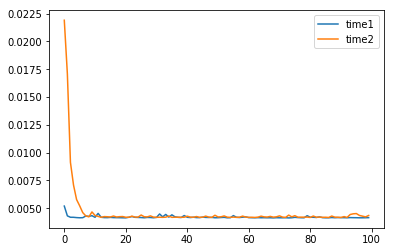

In [25]:
times_coords.plot(y=['time1', 'time2']);

# HDF5 Saving and loading

In [14]:
abbr = [metaedge.get_abbrev() for metaedge in metagraph.get_edges()]

In [15]:
h5file = tables.open_file('data/sparse_matrices.h5', mode='w', title='Adjacency Matrices')

for edge in abbr:
    group_path = f'{edge[0]}{edge[-1]}'
    try:
        h5file.create_group('/', group_path)
    except:
        pass
    r, c, sparse_matrix = metaedge_to_adjacency_matrix(graph, edge, sparse_threshold=1)
    group = h5file.create_group('/'+group_path+'/', edge)
    h5file.create_array(group, edge+'_data', sparse_matrix.data)
    h5file.create_array(group, edge+'_indices', sparse_matrix.indices)
    h5file.create_array(group, edge+'_indptr', sparse_matrix.indptr)
    h5file.create_array(group, edge+'_shape', sparse_matrix.shape)

h5file.close()

/home/michael/miniconda3/envs/hetmech/lib/python3.6/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'Gr>G'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/michael/miniconda3/envs/hetmech/lib/python3.6/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'Gr>G_data'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/michael/miniconda3/envs/hetmech/lib/python3.6/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'Gr>G_indices'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this objec

In [16]:
def pt_load_array(h5file, node):
    
    data = h5file.get_node(f'/{node[0]}{node[-1]}/{node}/{node}_data').read()
    indices = h5file.get_node(f'/{node[0]}{node[-1]}/{node}/{node}_indices').read()
    indptr = h5file.get_node(f'/{node[0]}{node[-1]}/{node}/{node}_indptr').read()
    mat_shape = h5file.get_node(f'/{node[0]}{node[-1]}/{node}/{node}_shape').read()
    return sparse.csc_matrix((data, indices, indptr), shape=mat_shape)

In [17]:
times_pt = []
for i in range(5000):
    t1 = time.time()
    h5file = tables.open_file('data/sparse_matrices.h5', 'a')

    sparse_ctd_load = pt_load_array(h5file, 'CtD')
    sparse_gig_load = pt_load_array(h5file, 'GiG')

    h5file.close()
    t2 = time.time()
    times_pt.append(t2-t1)

print(f'Average: {np.mean(times_pt)*1000 :.4} ms, Stdev: {np.std(times_pt)*1000 :.4} ms')

Average: 2.216 ms, Stdev: 0.1566 ms
